# Regression- Optimize and Save Models

In [16]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

### Data Preparation

In [17]:
# load training dataset, derive a feature, display summary statistics
bike_data = pd.read_csv('daily-bike-share.csv')
bike_data['day'] = pd.DatetimeIndex(bike_data['dteday']).day
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit', 'day']
bike_data[numeric_features + ['rentals']].describe()

,temp,atemp,hum,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000
mean,0.495385,0.474354,0.627894,0.190486,848.176471
std,0.183051,0.162961,0.142429,0.077498,686.622488
min,0.059130,0.079070,0.000000,0.022392,2.000000
25%,0.337083,0.337842,0.520000,0.134950,315.500000
50%,0.498333,0.486733,0.626667,0.180975,713.000000
75%,0.655417,0.608602,0.730209,0.233214,1096.000000
max,0.861667,0.840896,0.972500,0.507463,3410.000000


In [18]:
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals,day
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,1
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,2
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,3
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,4
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,5


In [19]:
# separate features and label
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print (f'Training Set: {X_train.shape[0]} rows\nTest Set: {X_test.shape[0]} rows')

Training Set: 511 rows
Test Set: 220 rows


### Algorithms

In [20]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# train the model
model = GradientBoostingRegressor().fit(X_train, y_train)
print(model, '\n')

GradientBoostingRegressor() 



In [21]:
# evaluate the model using the test set
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 103830.65935863409
RMSE: 322.2276514494591
R2: 0.7964465091178001


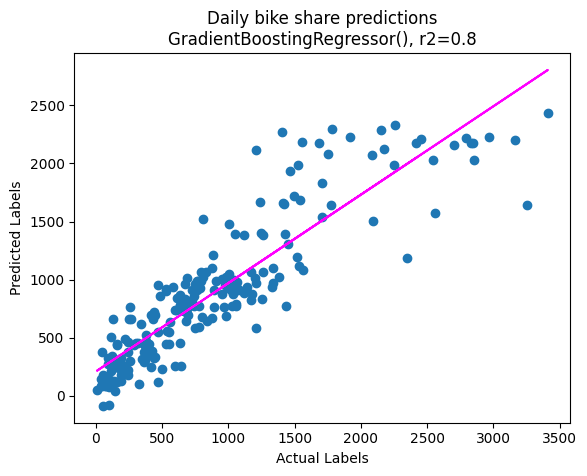

In [22]:
# plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Daily bike share predictions\n{model}, r2={round(r2, 2)}')

# overlay a regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

### Tuning Hyperparameters

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# use a gradient boosting algo
alg = GradientBoostingRegressor()

# try these hyperparameter values
params = {
    'learning_rate': [0.1, 0.5, 1.0],
    'n_estimators': [50, 100, 150],
}

# find best hyperparameter combination to optimize the r2 score metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, '\n')

# get best model
model = gridsearch.best_estimator_
print(model, '\n')

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 100} 

GradientBoostingRegressor() 



In [24]:
# evaluate the model using the test set
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 104568.5688233368
RMSE: 323.37063692199513
R2: 0.7949998839261364


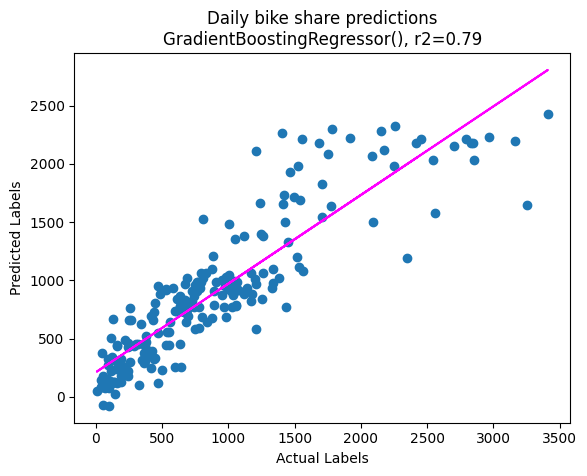

In [25]:
# plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Daily bike share predictions\n{model}, r2={round(r2, 2)}')

# overlay a regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

### Preprocessing Data and Pipelines

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

In [27]:
# define preprocessing for numeric columns- scaling
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# define preprocessing for categorical columns- encode them
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor())])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, y_train)
print(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', GradientBoostingRegressor())])


In [28]:
# get predictions for the test set
predictions = model.predict(X_test)

# display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 105370.04362797354
RMSE: 324.60752244514225
R2: 0.7934286428751243


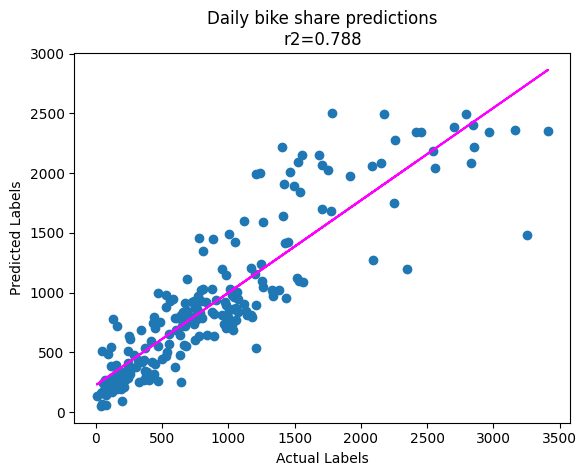

In [35]:
# plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Daily bike share predictions\nr2={round(r2, 3)}')

# overlay a regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

In [31]:
# use a different estimator in the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor())])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, y_train)
print(model, '\n')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [6, 7, 8, 9]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [0, 1, 2, 3, 4, 5])])),
                ('regressor', RandomForestRegressor())]) 



In [32]:
# get predictions for the test set
predictions = model.predict(X_test)

# display metrics
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

MSE: 107964.22636318182
RMSE: 328.57910214008103
R2: 0.7883429104431067


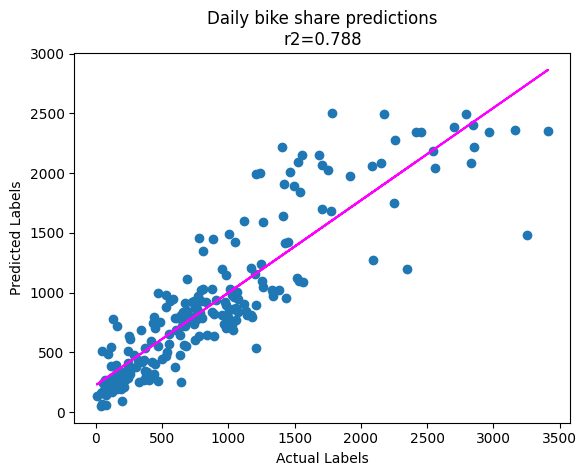

In [34]:
# plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title(f'Daily bike share predictions\nr2={round(r2, 3)}')

# overlay a regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),color='magenta')
plt.show()

### Saving and Using Trained Models

In [37]:
import joblib

# save the model as a pickle file
filename = './bike-share.pkl'
joblib.dump(model, filename)

['./bike-share.pkl']

Now the file with the model can be loaded to be used whenever needed, to predict labels for new data. This is called scoring or inferencing. 

In [38]:
# load the model from the file
loaded_model = joblib.load(filename)

# create a numpy array containing a new observation (for example, could be the values for tomorrow)
X_new = np.array([[1,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869]]).astype('float64')
print(f'New sample: {list(X_new[0])}')

New sample: [1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.226957, 0.22927, 0.436957, 0.1869]


In [39]:
# use the model to predict tomorrows rentals
result = loaded_model.predict(X_new)
print(f'Predicted Rentals: {np.round(result[0])}')

Predicted Rentals: 99.0


In [40]:
# can do the same with an array of features, maybe based on a 5 day weather forecast
X_new = np.array([[0,1,1,0,0,1,0.344167,0.363625,0.805833,0.160446],
                  [0,1,0,1,0,1,0.363478,0.353739,0.696087,0.248539],
                  [0,1,0,2,0,1,0.196364,0.189405,0.437273,0.248309],
                  [0,1,0,3,0,1,0.2,0.212122,0.590435,0.160296],
                  [0,1,0,4,0,1,0.226957,0.22927,0.436957,0.1869]])

# use the model to predict rentals
results = loaded_model.predict(X_new)
print("5-day rental predictions:")
for prediction in results:
    print(np.round(prediction))

5-day rental predictions:
580.0
842.0
253.0
186.0
260.0
